# Tutorial Introduction to the WeakLensingDeblending package

WeakLensingDeblending is a python package for perfoming fast pixel-level simulations of weak-lensing survey images, measuring pixel-level observables (SNR, shear, ...) and analyzing the effects of overlapping sources.

There is a lot more information at the following links, so this is just a quick tutorial introduction to get you started:
 * [Source code on github](https://github.com/DarkEnergyScienceCollaboration/WeakLensingDeblending)
 * [User and API documentation on readthedocs.org](http://weaklensingdeblending.readthedocs.org/en/latest/)

If you have any questions, suggestions for improvements, or think you have found a bug, please let us know by [creating a github issue](https://github.com/DarkEnergyScienceCollaboration/WeakLensingDeblending/issues).

## Installation

Assuming that you have already installed git, python (2.x), and GalSim:
```
git clone https://github.com/DarkEnergyScienceCollaboration/WeakLensingDeblending.git
```
To verify that your installation was successful, try:
```
cd WeakLensingDeblending
./simulate.py --help
```
You can now run this ipython notebook locally using:
```
cd notebooks
ipython notebook TutorialIntroduction.ipynb
```
See [here](http://weaklensingdeblending.readthedocs.org/en/latest/install.html) for more details on installation. The examples below are based on version 0.3 of the pacakge.

## Command-Line Scripts

The diagram below shows the basic workflow that this pacakge is designed for, with each command-line tool highlighted in blue:
![workflow](http://weaklensingdeblending.readthedocs.org/en/latest/_images/programs.png)

This tutorial focuses on the simulation and display steps. See [here](http://weaklensingdeblending.readthedocs.org/en/latest/programs.html) for more details on command-line scripts.

### Download a Galaxy Catalog

A simulation turns a galaxy catalog into pixels. You can provide your own catalog (in the [required format](http://weaklensingdeblending.readthedocs.org/en/latest/catalog.html#galaxy-catalog-format)) but it is easier to get started by downloading and uncompressing a [prepared catalog](ftp://ftp.slac.stanford.edu/groups/desc/WL/OneDegSq.fits.gz) into your package directory:
```
cd WeakLensingDeblending
curl -O ftp://ftp.slac.stanford.edu/groups/desc/WL/OneDegSq.fits.gz
gunzip OneDegSq.fits.gz
```
The resulting uncompressed FITS file is ~130 Mb and contains 1 square degree of the LSST DM CatSim catalog. Details on how this file was produced from CatSimSee are [here](http://weaklensingdeblending.readthedocs.org/en/latest/catalog.html#catalog-create).

### Run a Small Simulation

Scripts are not installed on your path, so you normally run them from the package's top-level directory.  To simulate a (very small) piece of an LSST i-band exposure, use:
```
./simulate.py --catalog-name OneDegSq.fits --image-width 300 --image-height 300 --output-name tutorial
```
The width and height parameters are specified in LSST pixels (0.2"/pixel), so this simulation only covers 1 sq.arcmin.  This simulation runs in about 45s on my laptop and produces a ~5Mb FITS output file called `tutorial.fits`.  To see the results with and without noise:
```
./display.py -i tutorial -o notebooks/display1.png --magnification 2
./display.py -i tutorial -o notebooks/display2.png --magnification 2 --add-noise 123
```
Each command opens a window displaying the simulated exposure at 2x scale (4 screen pixels per LSST pixel):

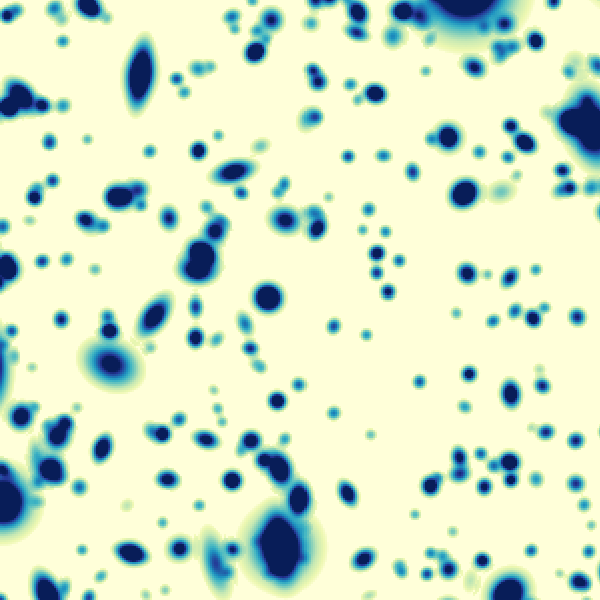

In [1]:
from IPython.display import Image
Image(filename='display1.png')

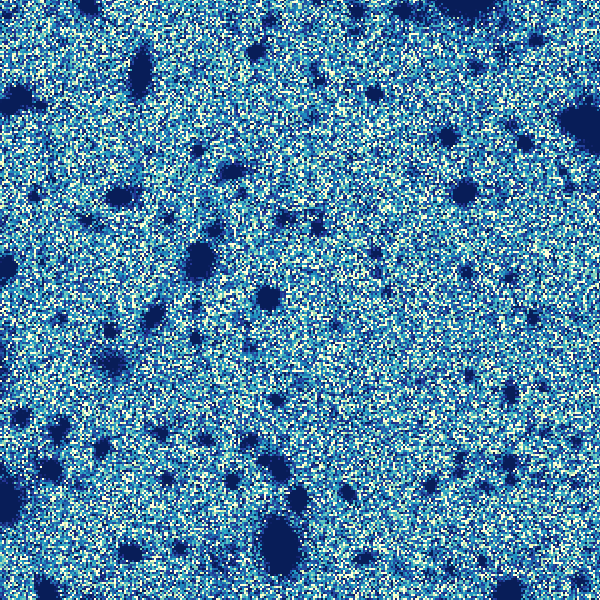

In [2]:
Image(filename='display2.png')

Close the window to exit the program.  The noise (generated with random seed 123) corresponds to a full-depth i-band stack of 6900s (230 visits).  For a complete list of the simulation options:
```
./simulate.py --help
```

### Display Metadata and Analysis Results

The FITS file generated by the `simulate.py` program includes a [catalog of metadata and analysis results](http://weaklensingdeblending.readthedocs.org/en/latest/output.html#analysis-results) You can annotate selected galaxies using any of this data with the `display.py` command, for example:
```
./display.py -i tutorial -o notebooks/display3.png --magnification 2 \
    --select 'snr_grpf>10' --select 'purity<0.99' \
    --info 'z=%(z).2f, i=%(ab_mag).1f' --info-color black --info-size x-large
```
In this example, we display the redshifts and magnitudes of galaxies with SNR > 10 that are blended (purity < 0.99) with other galaxies.

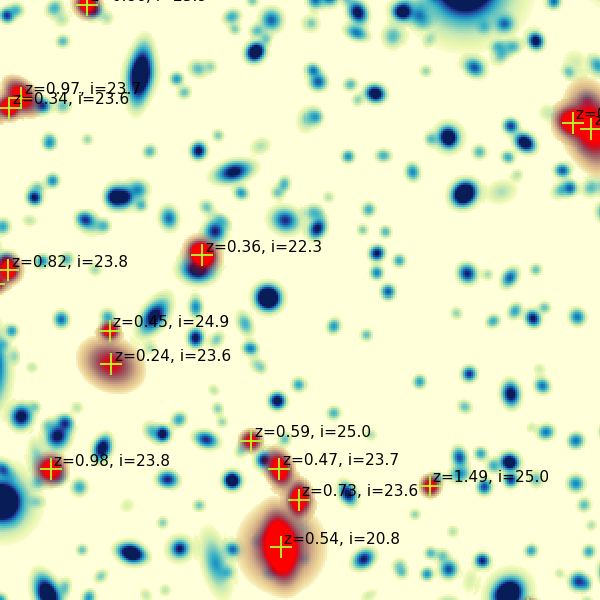

In [3]:
Image(filename='display3.png')

For a complete list of the display options:
```
./display.py --help
```

### Survey Configuration

The `simulate.py` program simulates full-depth LSST i-band exposures by default, but you can easily customize this. To select a different pre-defined configuration, use the `--survey-name` and `--filter-band` options, for example:
```
./simulate.py --survey-name LSST --filter-band r ...
./simulate.py --survey-name DES  --filter-band i ...
./simulate.py --survey-name CFHT --filter-band r ...
```
You can also modify the default settings of the [individual configuration parameters](http://weaklensingdeblending.readthedocs.org/en/latest/src/descwl.survey.html#descwl.survey.Survey).  For example, to simulate a single LSST r-band visit with better than average seeing at an airmass of 1.1:
```
./simulate.py --catalog-name OneDegSq.fits --image-width 300 --image-height 300 --output-name visit \
    --survey-name LSST --filter-band r --zenith-psf-fwhm 0.5 --airmass 1.1 --exposure-time 30
./display.py -i visit -o notebooks/display4.png --magnification 2 --add-noise 123 --select 'snr_grpf>10'
```

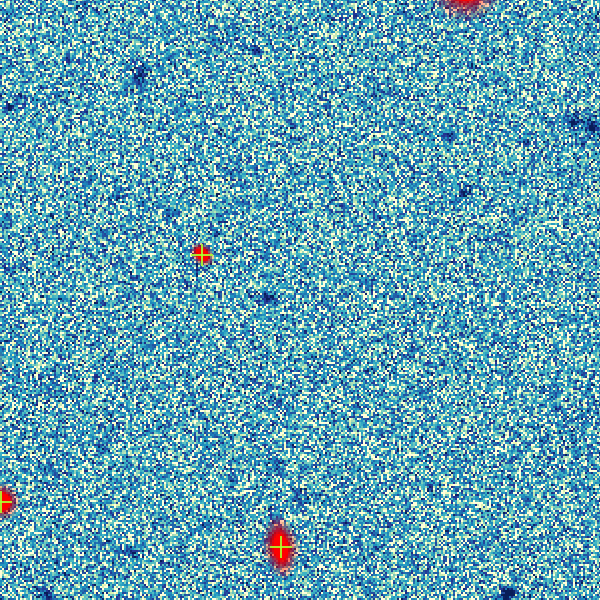

In [4]:
Image(filename='display4.png')

To view the default parameter values for all pre-defined configurations:
```
./simulate.py --survey-defaults
```

## Analysis

The following steps use interaction python. We start with some initialization.

In [5]:
%pylab inline
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


Instead of using command-line tools to inspect the simulation results, you can work directly with the output FITS file whose format is described [here](http://weaklensingdeblending.readthedocs.org/en/latest/output.html).

In [6]:
catalog = Table.read('../tutorial.fits', hdu=1)

Select the same galaxies that we annotated with redshifts in the earlier example. Column variables are documented [here](http://weaklensingdeblending.readthedocs.org/en/latest/output.html#analysis-results):

In [7]:
selected = (catalog['snr_grpf'] > 10) & (catalog['purity'] < 0.99)
print catalog[selected][['z', 'ab_mag', 'snr_grpf', 'purity', 'grp_size', 'grp_rank', 'e1', 'e2']]

   z      ab_mag snr_grpf  purity  grp_size grp_rank     e1         e2    
-------- ------- -------- -------- -------- -------- ---------- ----------
 1.49172 24.9983  10.4331 0.983377        9        1  -0.179051 -0.0198583
0.173012 24.8832  17.1102 0.954458       11        1   0.047649  -0.182221
 0.77425 22.8608  59.0179 0.869086       15        1   0.136624  -0.114638
0.921194 22.0377  51.2511 0.920814       15        0  -0.274653  -0.140387
 1.72421 25.2077  10.1832 0.877931       19        4 -0.0983126 -0.0924841
0.358113 22.2711  129.017 0.988883        9        0 -0.0103377  -0.587743
0.974496 23.6693  29.4385 0.919529        6        1  -0.055513  -0.352782
0.546395 24.4869  18.1168 0.951419       27        4   0.153117    0.10092
0.822417 23.8006  10.2347 0.902523       27        2  -0.291287 -0.0994362
0.337734 23.5804  52.9899 0.970445        6        0  -0.312457 -0.0743649
0.737692 24.0761  25.8887 0.987987        6        2 0.00601644   0.049435
0.859595 23.8931  10.3433

Calculate the intrinsic ellipticity for galaxies with SNR > 5:

In [8]:
sample = catalog['snr_grpf'] > 5
sigint = 0.5 * (np.std(catalog['e1'][sample]) + np.std(catalog['e1'][sample]))
print 'RMS intrinsic ellipticity = {:.3f}'.format(sigint)

RMS intrinsic ellipticity = 0.242


Calculate the average of the +,x shape measurement errors, taking into account the statistical loss of precision due to blending:

In [9]:
dgerr = np.clip(0.5 * (catalog[sample]['dg1_grp'] + catalog[sample]['dg2_grp']), 0., 1.)

How do shape measurement errors scale with SNR?

/Users/david/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


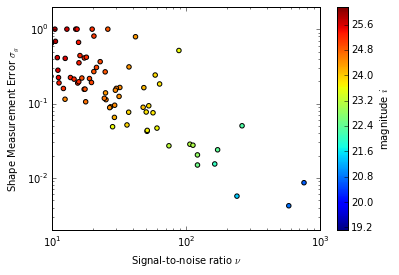

In [10]:
plt.scatter(catalog[sample]['snr_grp'], dgerr, c=catalog[sample]['ab_mag'])
plt.xlabel('Signal-to-noise ratio $\\nu$')
plt.ylabel('Shape Measurement Error $\sigma_g$')
plt.colorbar().set_label('magnitude $i$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10., 1000.)
plt.ylim(2e-3, 2)
plt.show()

Calculate the effective density of perfectly measured galaxies for shear estimation in this SNR > 5 sample:

In [11]:
neff = np.sum(sigint**2 / (sigint**2 + dgerr**2))
print 'neff = {:.2f} in 1 sq. arcmin.'.format(neff)

neff = 48.77 in 1 sq. arcmin.


### Galaxy Parameter Estimation

A simulation calculates the mean detected flux for each pixel (in electrons) from each source individually.  It also calculates numerical partial derivatives with respect to a galaxy's flux, size and shape parameters:
```
./fisher.py --i tutorial -o notebooks/display5.png --galaxy 402703350730 --partials --label-color black
```

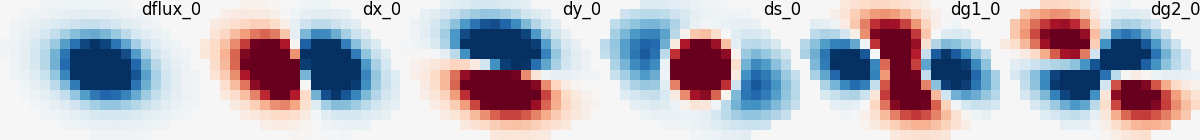

In [12]:
Image(filename='display5.png')

bThese partial derivative images are then combined to calculate Fisher matrix images:

$$
C^{-1}_{\mu\nu} \simeq \sum_{\text{pixels}}\, \frac{\partial_{\mu}f \partial_{\nu}f}{f + b}
$$

The `fisher.py` program can display these Fisher-matrix images:
```
./fisher.py --i tutorial -o notebooks/display6.png --galaxy 402703350730 --label-color black
```

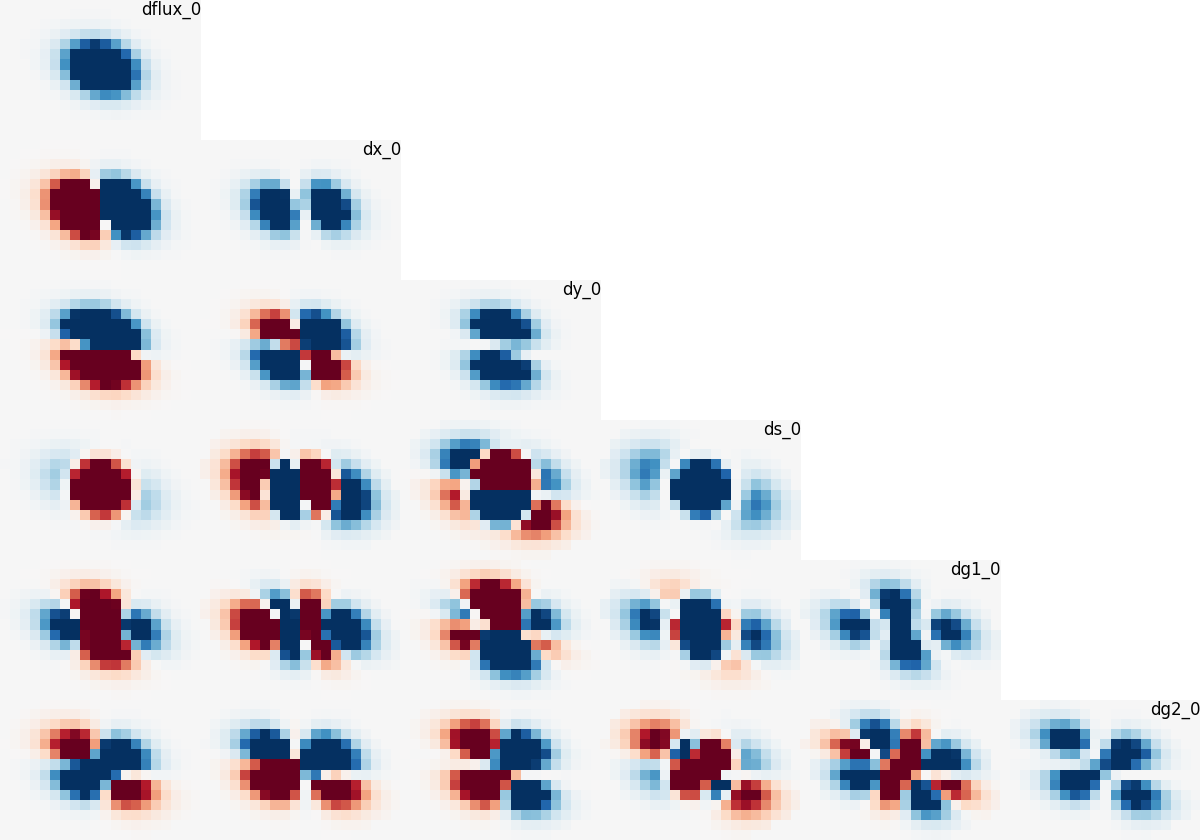

In [13]:
Image(filename='display6.png')

You can also display the resulting parameter covariance and correlation matrices:
```
./fisher.py --i tutorial -o notebooks/display7.png --galaxy 402703350730 --correlation \
    --label-color black --figure-size 6
```

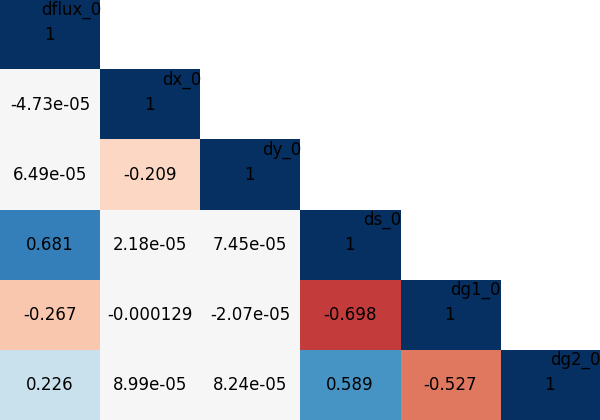

In [14]:
Image(filename='display7.png')

When two or more galaxies overlap, covariances are estimated two ways: first, treating each galaxy as if it is isolated on the sky and, second, taking into account the parameter correlations that result from the actual blending. Here is an example of the fully correlated calculation for a two-galaxy blend:
```
./fisher.py -i tutorial -o notebooks/display8.png --group 2209410830 --no-labels
```

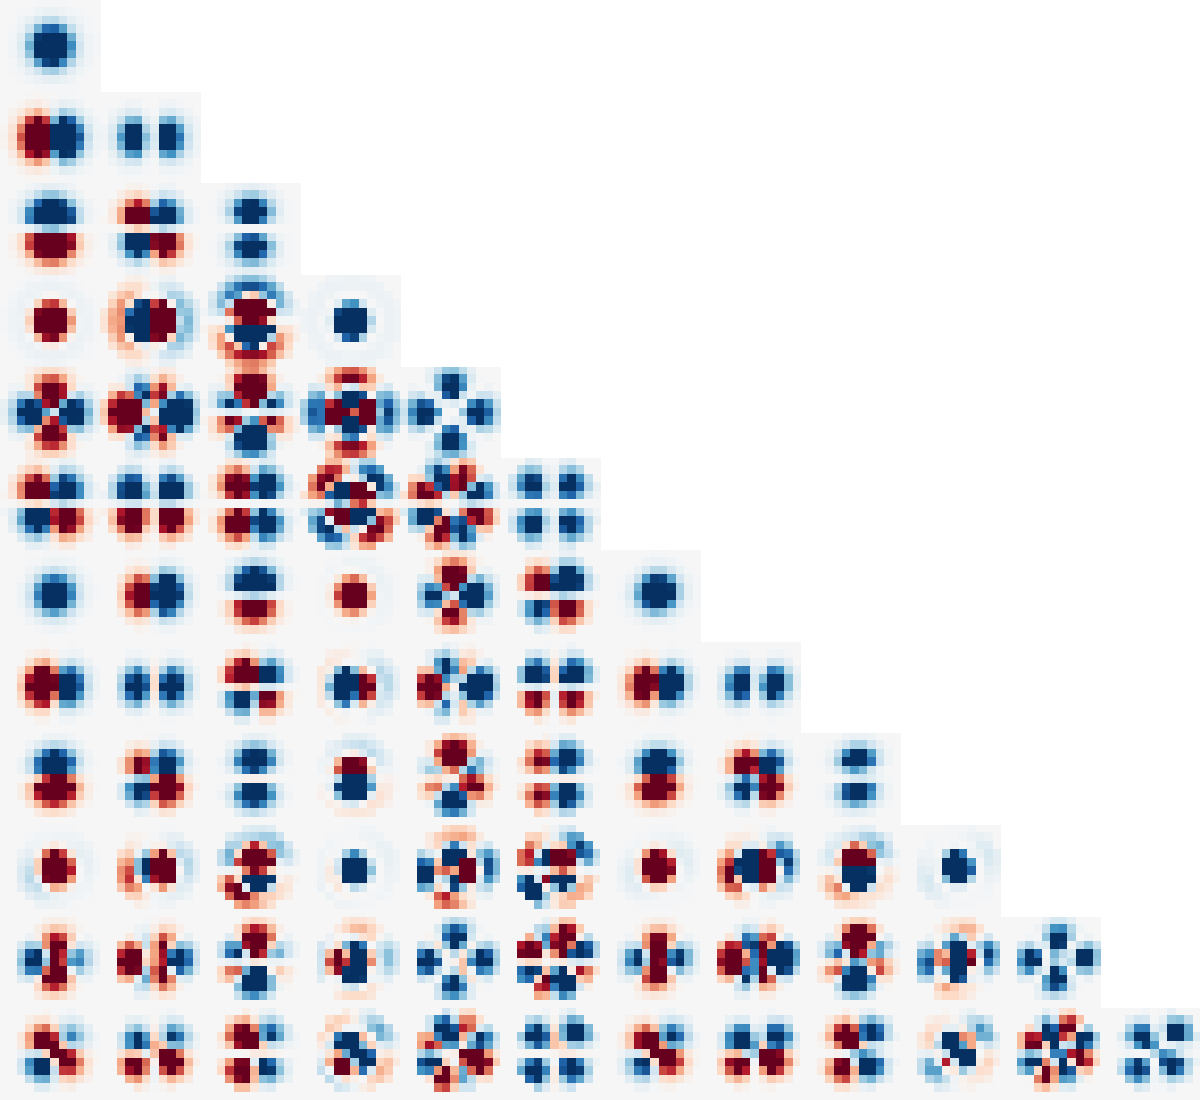

In [15]:
Image(filename='display8.png')

For a complete list of the Fisher matrix options:
```
./fisher.py --help
```

## Next Steps

If you made it this far, here are some next steps to try:
* Create a [github issue](https://github.com/DarkEnergyScienceCollaboration/WeakLensingDeblending/issues) to ask your questions, request new features, or let us know about bugs.
* Use the [skeleton analysis code](https://github.com/DarkEnergyScienceCollaboration/WeakLensingDeblending/blob/master/skeleton.py) to perform your own analysis of the [simulation outputs](http://weaklensingdeblending.readthedocs.org/en/latest/output.html).
* Provide your own [custom catalog](http://weaklensingdeblending.readthedocs.org/en/latest/catalog.html#galaxy-catalog-format) as input to a simulation.
* Add your own [analysis code](http://weaklensingdeblending.readthedocs.org/en/latest/src/descwl.analysis.html) to modify or extend the current [simulation outputs](http://weaklensingdeblending.readthedocs.org/en/latest/output.html).
* Add [defaults parameter values](http://weaklensingdeblending.readthedocs.org/en/latest/src/descwl.survey.html#descwl.survey.Survey.get_defaults) for your favorite survey.
* Sign up for a project on the [TODO list](http://weaklensingdeblending.readthedocs.org/en/latest/todo.html).